In [169]:
from pathlib import Path
from skimage.transform import resize
import skimage
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt


cube_config = re.compile(r"[rgboyw]{27}")

def create_dataset(path):
    images = []
    configs = []

    training_set = Path(path)
    for i, file_path in enumerate(training_set.glob("*")):
        bla = cube_config.search(file_path.stem)
        if bla is None:
            continue
        image = skimage.io.imread(file_path)
        image = image[:,:,:3]  # discard alpha
        image = resize(image, (128, 128), anti_aliasing=True)
        config = bla.group(0)
        images.append(image)
        configs.append(config)

    training_set_x = np.array(images)
    training_set_y = np.zeros(shape=(len(configs), 27*6))
    color_indexes = {c:i for i, c in enumerate("rgbowy")}

    for i, config in enumerate(configs):
        for j, color in enumerate(config):
            c = color_indexes[color]
            training_set_y[i][j*6 + c] = 1

    return training_set_x, training_set_y

train_x, train_y = create_dataset("training_set")
train_y = train_y.reshape(-1, 27, 6)
# print(training_set_x.shape)
# print(training_set_y.shape)

In [181]:
import tensorflow as tf


conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(30, (3,3), input_shape=(128, 128, 3), kernel_initializer="random_uniform"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), kernel_initializer="random_uniform"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(800, activation="relu"),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(27*6, activation="tanh"),
    tf.keras.layers.Reshape((27, 6)),
    tf.keras.layers.Activation("softmax"),
],
name="Cube"
)

# tf.keras.utils.set_random_seed(123)
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

conv_model.compile(
    "adam",
    loss="categorical_crossentropy",
    # loss="mean_squared_error",
    metrics=['accuracy'],
    # opt=opt,
)
conv_model.build(train_x.shape, )
conv_model.summary()

Model: "Cube"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 126, 126, 30)      840       
                                                                 
 max_pooling2d_124 (MaxPool  (None, 63, 63, 30)        0         
 ing2D)                                                          
                                                                 
 conv2d_125 (Conv2D)         (None, 61, 61, 10)        2710      
                                                                 
 max_pooling2d_125 (MaxPool  (None, 30, 30, 10)        0         
 ing2D)                                                          
                                                                 
 flatten_62 (Flatten)        (None, 9000)              0         
                                                                 
 dense_157 (Dense)           (None, 800)               7200800

Epoch 1/50
1/1 [==============================] - 0s 433ms/step - loss: 1.7921 - accuracy: 0.1503
Epoch 2/50
1/1 [==============================] - 0s 37ms/step - loss: 1.7298 - accuracy: 0.0763
Epoch 3/50
1/1 [==============================] - 0s 40ms/step - loss: 1.6685 - accuracy: 0.0741
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 1.6362 - accuracy: 0.0545
Epoch 5/50
1/1 [==============================] - 0s 38ms/step - loss: 1.6182 - accuracy: 0.0458
Epoch 6/50
1/1 [==============================] - 0s 39ms/step - loss: 1.5974 - accuracy: 0.0370
Epoch 7/50
1/1 [==============================] - 0s 37ms/step - loss: 1.5776 - accuracy: 0.0414
Epoch 8/50
1/1 [==============================] - 0s 38ms/step - loss: 1.5590 - accuracy: 0.0414
Epoch 9/50
1/1 [==============================] - 0s 38ms/step - loss: 1.5371 - accuracy: 0.0414
Epoch 10/50
1/1 [==============================] - 0s 38ms/step - loss: 1.5249 - accuracy: 0.0392
Epoch 11/50
1/1 [===========

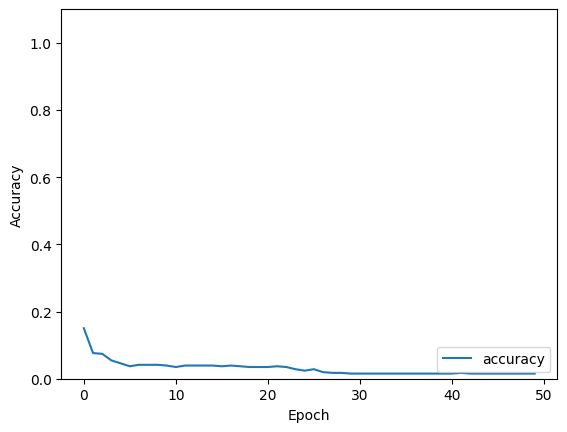

In [182]:
results = conv_model.fit(
    train_x,
    train_y.reshape(-1, 27, 6),
    epochs=50,
)

bla = conv_model.predict(train_x)

plt.plot(results.history['accuracy'], label='accuracy')
# plt.plot(results.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [178]:
print(bla[0])
print(train_y[0])

[[0.0807164  0.08071641 0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.0807164  0.0807164  0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.0807164  0.0807164  0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.0807164  0.08071642 0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.08071639 0.08071643 0.59641796 0.08071639 0.08071639 0.08071639]
 [0.0807164  0.0807164  0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.0807164  0.0807164  0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.0807164  0.0807164  0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.0807164  0.08071643 0.596418   0.0807164  0.0807164  0.0807164 ]
 [0.39349303 0.05325349 0.05325349 0.05325349 0.39349303 0.05325349]
 [0.59641796 0.08071639 0.08071639 0.08071639 0.08071639 0.08071639]
 [0.59641796 0.08071639 0.08071639 0.08071641 0.08071639 0.08071639]
 [0.59640026 0.08071399 0.08071399 0.08074375 0.08071399 0.08071399]
 [0.59641796 0.08071639 0.08071639 0.08071639 0.08071639 0.08071639]
 [0.5964171  0.08071628 0.08071628